In [1]:
import sys
sys.path.append('../')
from model.VQAE import VQAE
from utils import device, add_noise
from tqdm import tqdm
import torch
from data.FloorPlanLoader import *
import torch.nn.functional as F
import random
import json
import torchvision
import matplotlib.pyplot as plt
import geopandas as gpd

USE_MULTISCALE = True
USE_MULTITASK = True

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy


import torchvision
import torchvision.transforms.functional as TF
import imageio
from torchvision.utils import save_image
# %load_ext autoreload
# %autoreload 2
import csv
import numpy
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import pandas as pd
import seaborn as sns
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [5]:
#Hyperparameter
device = 'cpu'
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
noise=False
noise_weight=0.05
img_channel=3
vqae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
checkpoint = torch.load("../best_checkpoint/final/55-vqae-0.04753296934928414.pt", map_location=torch.device('cpu'))
vqae.load_state_dict(checkpoint)
for param in vqae.parameters():
    param.to('cpu')

### prepare latent.pt file

In [13]:
#Load Dataset
curr_data = 'data20_right'
floor = FloorPlanDataset(multi_scale=True, root=f'../data/data_root/{curr_data}/',\
                         data_config='../data/data_config/', preprocess=True)
data_loader = torch.utils.data.DataLoader(floor, batch_size=218, shuffle=False)

for param in vqae.parameters():
    param.to('cpu')

latents = None
with torch.no_grad():
    for data in tqdm(data_loader):
        data = data['image_tensor'].to(device)
        img_encoding = vqae.encode(data)
        if latents is not None:
            latents = torch.cat([latents, img_encoding], dim=0)
        else: 
            latents = img_encoding
        
latent_file_path = f'../data/data_root/vqae_latent_{curr_data}.pt'
torch.save(latents, latent_file_path)
print(latents[0].shape)
print(f"latent saved to {latent_file_path} ...")

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [01:11<00:00,  1.49s/it]


torch.Size([32, 28, 28])
latent saved to ../data/data_root/vqae_latent_data20_right.pt ...


# Embedding Space Visualization
## Visualize the latent with UMAP and T-SNE

In [144]:
curr_data = 'data20_right'
latent_file_path = f'../data/data_root/vqae_latent_{curr_data}.pt'
latents = torch.load(latent_file_path)
floor = FloorPlanDataset(multi_scale=True, root=f'../data/data_root/{curr_data}/',\
                         data_config='../data/data_config/', preprocess=True)
data_loader = torch.utils.data.DataLoader(floor, batch_size=batch_size, shuffle=False)

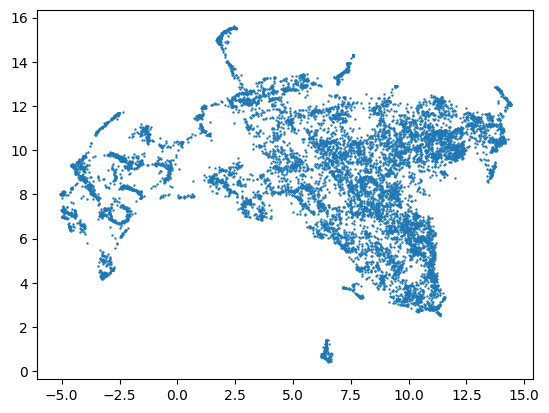

In [145]:
from umap import UMAP

umap = UMAP(n_components=2)
data_2d_umap = umap.fit_transform(torch.flatten(latents, start_dim=1).cpu())
# Create a figure and a 3D axes object
fig = plt.figure()
ax = fig.add_subplot(111)

# Create the initial scatter plot
ax.scatter(data_2d_umap[:, 0], data_2d_umap[:, 1], s=0.5)

# Show the plot
plt.show()

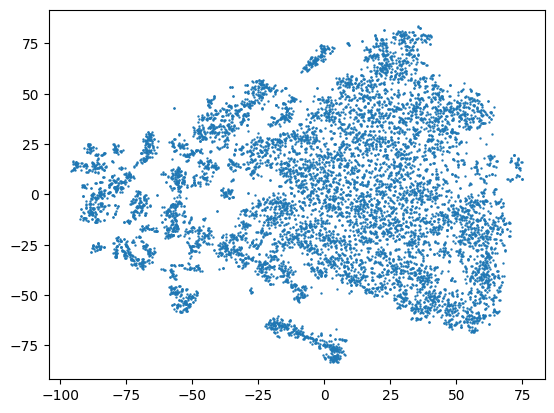

In [146]:
tsne = TSNE(n_components=2)
# apply t-SNE to data
data_2d_tsne = tsne.fit_transform(torch.flatten(latents, start_dim=1).cpu())
# Create a figure and a 3D axes object
fig = plt.figure()
ax = fig.add_subplot(111)

# Create the initial scatter plot
ax.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], s=0.5)

# Show the plot
plt.show()

### deciding the number of clusters

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\xinwei\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  5%|████▏                                                                              | 1/20 [00:23<07:29, 23.66s/it]C:\Users\xinwei\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 10%|████████▎                                                                          | 2/20 [02:24<24:15, 80.87s/it]C:\Users\xinwei\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarni

ValueError: x and y must have same first dimension, but have shapes (19,) and (20,)

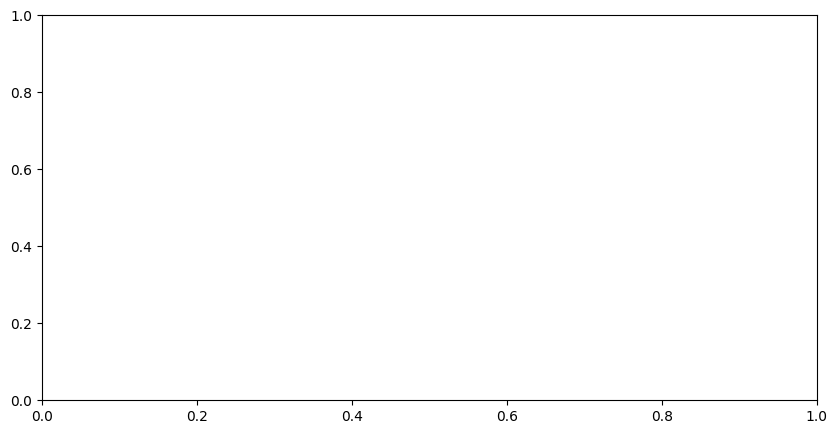

In [30]:
def calculate_wcss(latents):
    wcss = []
    for n in tqdm(range(2, 21)):  # change the range according to your needs
        kmeans = KMeans(n_clusters=n)
        data = torch.flatten(latents, start_dim=1).cpu()
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)  # inertia_ is the WCSS for the model
    return wcss



# calculate WCSS for different numbers of clusters
wcss = calculate_wcss(latents)



In [32]:
wcss

[986140.499339175,
 869505.0606631708,
 819694.0209426743,
 785642.1990883268,
 760934.4728065955,
 745724.7869051867,
 734105.2118314499,
 722259.5009777081,
 711904.7535994987,
 702508.9690809237,
 694584.8212776463,
 687067.6198292032,
 680649.9389668355,
 674773.3688534827,
 669926.692170877,
 665193.4642194572,
 661639.4121179607,
 658217.1916727715,
 654436.3704479537,
 651240.404522262]

In [34]:
# Convert list to DataFrame
wcss_df = pd.DataFrame(wcss)
wcss_df.to_csv('wcss.csv',index=False)
wcss_df

,0
0,986140.499339
1,869505.060663
2,819694.020943
3,785642.199088
4,760934.472807
5,745724.786905
6,734105.211831
7,722259.500978
8,711904.753599
9,702508.969081


In [39]:
def plot_elbow(wcss, filename=None):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(wcss) + 1), wcss, 'bo-')
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.grid()
    filename = 'elbow plot for k-means'
    plt.savefig(filename)

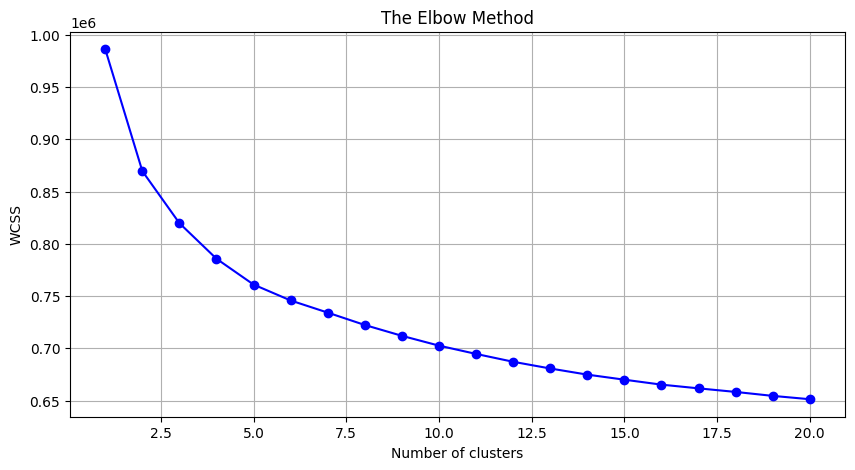

In [40]:
# plot the elbow graph
plot_elbow(wcss)

the number of clusters are set to 5, 10, 15

In [46]:
def calculate_slope(points):
    slopes = []
    for i in range(len(points) - 1):
        slope = (points[i + 1] - points[i]) / (i + 2 - i)
        slopes.append(slope)
    return slopes

def find_optimal_point(slopes, drop_threshold=0.1):
    optimal_point = 1
    for i in range(len(slopes)):
        if slopes[i] / slopes[i - 1] <= drop_threshold:
            optimal_point = i + 1
            break
    return optimal_point

In [48]:
# Calculate slopes
slopes = calculate_slope(wcss)
print(slopes)
# Find the optimal point based on the slope
optimal_point = find_optimal_point(slopes)

print("Optimal point:", optimal_point)

[-58317.71933800209, -24905.519860248256, -17025.91092717374, -12353.863140865637, -7604.842950704391, -5809.787536868418, -5922.8554268708685, -5177.373689104745, -4697.892259287473, -3962.0739016386797, -3758.6007242215564, -3208.8404311838676, -2938.2850566764246, -2423.3383413028205, -2366.6139757098863, -1777.0260507482453, -1711.110222594638, -1890.4106124088867, -1597.9829628458247]
Optimal point: 1


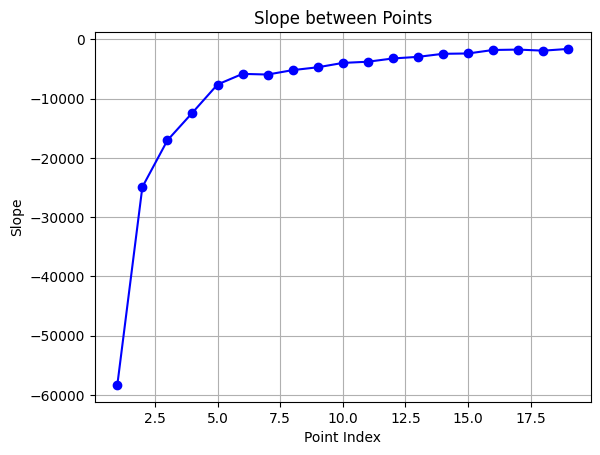

In [49]:
# Plot the slopes
plt.plot(range(1, len(wcss)), slopes, 'bo-')
plt.title('Slope between Points')
plt.xlabel('Point Index')
plt.ylabel('Slope')
plt.grid()
plt.show()

### Clustering

In [147]:
print(data_2d_umap.shape)
print(data_2d_tsne.shape)

(10450, 2)
(10450, 2)


In [148]:
n_clusters=5
data_latent = latents # this is the high-dim data for clustering

In [149]:
#Initialize the class object
kmeans = KMeans(n_clusters=n_clusters)
data = torch.flatten(data_latent, start_dim=1).cpu()
# #predict the labels of clusters.
label = kmeans.fit_predict(data)
# get cluster centers
cluster_centers = kmeans.cluster_centers_
closest, _ = pairwise_distances_argmin_min(cluster_centers, data)
print(cluster_centers.shape, data.shape)



center_list = closest
print(center_list)
df = np.stack((label, floor.all_data_dirs)).transpose()
df = pd.DataFrame(df,columns=['label','data'])

C:\Users\xinwei\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(5, 25088) torch.Size([10450, 25088])
[ 109 8471 7633 3143 5337]


In [150]:
center_list

array([ 109, 8471, 7633, 3143, 5337], dtype=int64)

In [151]:
# Save closest points and cluster centers to CSV
df_center = pd.DataFrame({'Cluster Center': cluster_centers.tolist(), 'Closest Point Index': closest})
df_center.to_csv(f'../results/VQAE_{curr_data}_{n_clusters}cluster_centers.csv', index=False)

df_center_index = np.stack((label, floor.all_data_dirs)).transpose()
df_center_index = pd.DataFrame(df_center_index,columns=['label','data'])
df_center_index['index'] = df_center_index['data'].str.extract(r'(\d+).pt')
df_center_index = df_center_index.drop(['data'], axis=1)
df_center_index['index'] = df_center_index['index'].astype(int)
df_center_index.to_csv(f'../results/VQAE_{curr_data}_{n_clusters}clusters_clusterindex.csv', index=False)
print(df_center_index.shape)
df_center_index.head(2)


(10450, 2)


,label,index
0,1,523336
1,0,523337


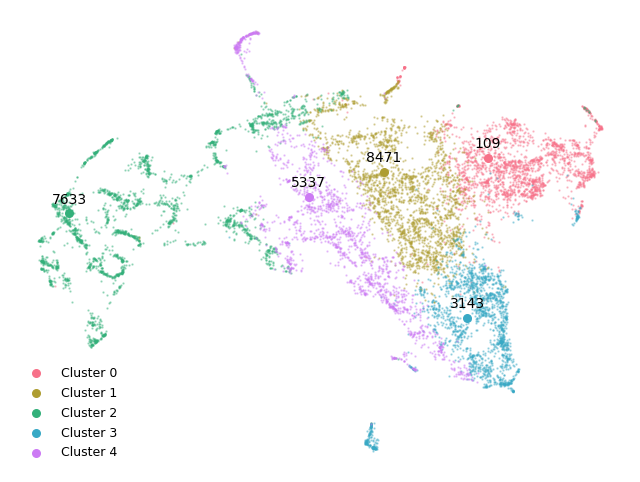

In [152]:
data_2d = data_2d_umap # this is the data for visualization
dim_name = 'umap'

#Getting unique labels
plt.figure(figsize=(8,6))
u_labels = np.unique(label)
num_labels = len(u_labels)
color_palette = sns.color_palette('husl', num_labels)
for i, each in enumerate(center_list):
    plt.scatter(data_2d[each][0],data_2d[each][1], s=30, c=[color_palette[i]])
    plt.annotate(each, (data_2d[each][0],data_2d[each][1]), ha="center", va="center", xytext=(0,10), textcoords='offset points')
for i in u_labels:
    plt.scatter(data_2d[label == i , 0] , data_2d[label == i , 1] , label=f"Cluster {i}", s=0.5, c=[color_palette[i]],alpha=0.4)
legend = plt.legend(loc='lower left', ncol=1, frameon=False)
for legend_handle in legend.legend_handles:
    legend_handle.set_sizes([30])  # Increase the size of legend dots    
    legend_handle.set_alpha(1)
plt.setp(legend.texts, fontsize='9')
plt.axis('off')
plt.savefig(f'VQAE_{curr_data}_{dim_name}_{n_clusters}_kmeans.png')

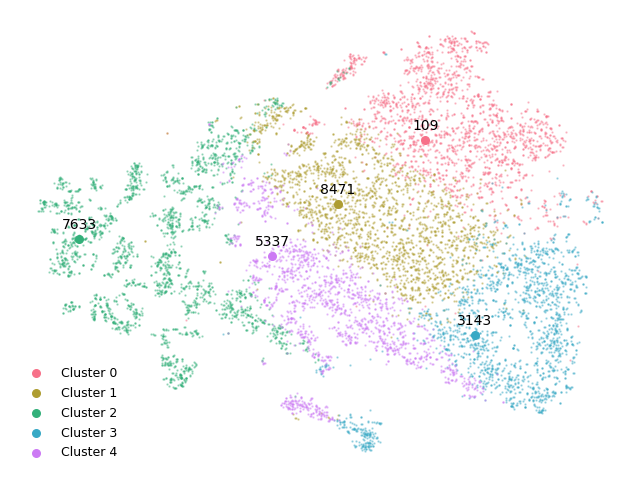

In [153]:
data_2d = data_2d_tsne # this is the data for visualization
dim_name = 'tsne'

#Getting unique labels
plt.figure(figsize=(8,6))
u_labels = np.unique(label)
num_labels = len(u_labels)
color_palette = sns.color_palette('husl', num_labels)
for i, each in enumerate(center_list):
    plt.scatter(data_2d[each][0],data_2d[each][1], s=30, c=[color_palette[i]])
    plt.annotate(each, (data_2d[each][0],data_2d[each][1]), ha="center", va="center", xytext=(0,10), textcoords='offset points')
for i in u_labels:
    plt.scatter(data_2d[label == i , 0] , data_2d[label == i , 1] , label=f"Cluster {i}", s=0.5, c=[color_palette[i]],alpha=0.4)
legend = plt.legend(loc='lower left', ncol=1, frameon=False)
for legend_handle in legend.legend_handles:
    legend_handle.set_sizes([30])  # Increase the size of legend dots 
    legend_handle.set_alpha(1)
plt.setp(legend.texts, fontsize='9')
plt.axis('off')
plt.savefig(f'VQAE_{curr_data}_{dim_name}_{n_clusters}_kmeans.png')

## Visualize the cluster center

In [154]:
center_list

array([ 109, 8471, 7633, 3143, 5337], dtype=int64)

In [155]:
# n_clusters=5
# # data_2d = data_2d_umap
# # data = data_2d_umap
# cluster_count = n_clusters
# file_path = f"../results/clustercenter/umap_{cluster_count}cluster_centers.csv"
# indexes = pd.read_csv(file_path)['Closest Point Index'].tolist()
# indexes

In [156]:
def scale_crop(img): #B,C,H,W
    rescale = transforms.Compose([transforms.Resize(112),
                                  transforms.CenterCrop(56)])
    return rescale(img)

In [157]:
indexes = center_list
cluster_count = 5

C:\Users\xinwei\miniconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB d

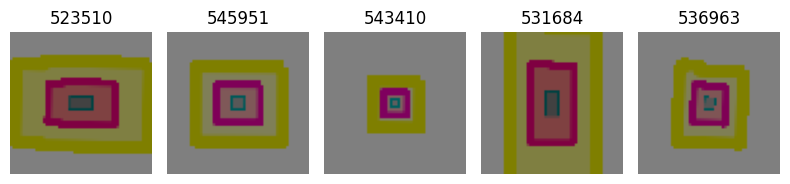

In [158]:
# Create a figure and axes with `cluster_count` subplots
fig, axes = plt.subplots(1, cluster_count, figsize=(8, 3))
image_size = 112
crop_size = 56

# Iterate over the `cluster_count` subplots
for i, index in enumerate(indexes):
    image_path = floor.all_data_dirs[index]
    # Read the image using torch's load
    image = torch.load(image_path)
    scaled = scale_crop(image)
    # Display the image in the corresponding subplot
    image_array = scaled.permute(1, 2, 0).numpy()  # Convert to (56, 56, 3) shape
    axes[i].imshow(image_array, cmap='gray')
    axes[i].set_title(os.path.basename(image_path).split(".")[0])
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig(f"../results/recon_img/VQAE_{curr_data}_{cluster_count}cluster_sample_multiscale.png")

In [159]:
def get_zoomed_img(image_path, half_pixel):
    image = mpimg.imread(image_path)
    # Get the center coordinates
    height, width, _ = image.shape
    center_x = width // 2
    center_y = height // 2
    
    # Calculate the coordinates for the center 150x150 pixels
    x1 = center_x - half_pixel
    x2 = center_x + half_pixel
    y1 = center_y - half_pixel
    y2 = center_y + half_pixel
    
    # Extract the center 150x150 pixels from each image
    center_img = image[y1:y2, x1:x2]
    return center_img

[523510, 545951, 543410, 531684, 536963]

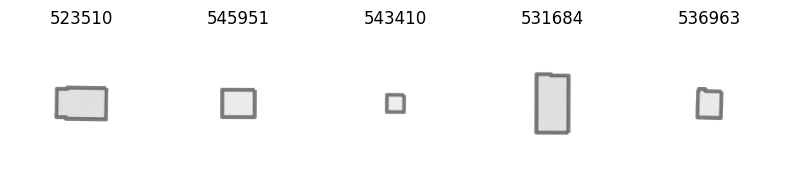

In [160]:
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

cluster_count = 5
# Create a figure and axes with `cluster_count` subplots
fig, axes = plt.subplots(1, cluster_count, figsize=(8, 3))
image_size = 112
crop_size = 56

# Define the new directory
new_dir = 'kmeans_5_cluster'
num_indexes = []
# Create the new directory if it doesn't exist
if not os.path.exists(new_dir):
    os.makedirs(new_dir)

# Iterate over the `cluster_count` subplots
for i, index in enumerate(indexes):
    image_path = floor.all_data_dirs[index]
    # Split the path into the name and the extension
    file_name, file_extension = os.path.splitext(image_path)
    # Replace the '.pt' extension with '.png'
    png_file_path = file_name + '.png'
    # Read the image data
    img = get_zoomed_img(png_file_path, 75)
    # Display the image in the corresponding subplot
    axes[i].imshow(img, cmap='gray')
    # Extract numerical part from the file name
    num_index = int(os.path.basename(file_name))
    num_indexes.append(num_index)
    axes[i].set_title(f"{num_index}")
    axes[i].axis('off')

    # Add the prefix 'VQAE_' to the original filename
    basename = os.path.basename(file_name)
    # Add the prefix 'VQAE_' to the basename
    new_basename = f'VQAE_{curr_data}_{basename}.png'
    # Copy the PNG file to the new directory with the modified filename
    shutil.copy(png_file_path, os.path.join(new_dir, new_basename))

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig(f"../results/recon_img/VQAE_{curr_data}_{cluster_count}cluster_sample.png")
num_indexes

## calculate aggregated area

In [161]:
# metadata_file_path = r"..\data\data_root\building_metadata.csv"
# metadata_df = pd.read_csv(metadata_file_path)
# metadata_df_clean = metadata_df[['OBJECTID','vintage','idf.kw', 'FootprintArea.m2', 'building.area.m2', 'HEIGHT']]
# metadata_df_clean = metadata_df_clean[metadata_df_clean['idf.kw'].str.contains('Family')]
# metadata_df_clean.to_csv(r"..\data\data_root\building_metadata_clean.csv", index=None)

In [162]:
# metadata_file_path = r"..\data\data_root\building_metadata_clean.csv"
# metadata_df = pd.read_csv(metadata_file_path, index_col=False)
# metadata_df.head(5)

In [163]:
merged_df = pd.merge(df_center_index, metadata_df, left_on='index', right_on = 'OBJECTID', how='inner')
print(df_center_index.shape, merged_df.shape)
merged_df

(10450, 2) (5427, 8)


,label,index,OBJECTID,vintage,idf.kw,FootprintArea.m2,building.area.m2,HEIGHT
0,0,523337,523337,before 1980,SingleFamily-pre-1980,241.960269,134.0547,15.91
1,0,523342,523342,before 1980,SingleFamily-pre-1980,149.499996,121.7919,13.30
2,3,523347,523347,before 1980,SingleFamily-pre-1980,90.063331,79.6153,17.41
3,3,523348,523348,before 1980,MultiFamily-pre-1980,477.608302,686.8097,23.49
4,2,523350,523350,before 1980,SingleFamily-pre-1980,248.998929,159.4164,20.37
...,...,...,...,...,...,...,...,...
5422,2,549695,549695,before 1980,MultiFamily-pre-1980,166.445802,136.8417,12.87
5423,3,549700,549700,before 1980,MultiFamily-pre-1980,193.290896,243.3980,24.05
5424,1,549701,549701,before 1980,SingleFamily-pre-1980,118.928201,92.6213,13.33
5425,1,549703,549703,before 1980,MultiFamily-pre-1980,380.560834,607.7518,19.19


In [164]:
grouped_df_lab = merged_df.groupby('idf.kw')['building.area.m2'].sum().reset_index()
grouped_df_lab.to_csv(f"kmeans_5_cluster/VQAE_{curr_data}_{cluster_count}cluster_area_aggregation_lab.csv")
grouped_df_lab

,idf.kw,building.area.m2
0,MultiFamily-2004,84957.3287
1,MultiFamily-2013,1217.0829
2,MultiFamily-pre-1980,310351.1229
3,SingleFamily-2004,116576.4011
4,SingleFamily-2013,368.8130
5,SingleFamily-pre-1980,483478.1694


In [165]:
grouped_df = merged_df.groupby('label')['building.area.m2'].sum().reset_index()
grouped_df['index'] = df_center['Closest Point Index']
grouped_df.to_csv(f"kmeans_5_cluster/VQAE_{curr_data}_{cluster_count}cluster_area_aggregation.csv")
grouped_df

,label,building.area.m2,index
0,0,184630.8535,109
1,1,217995.3311,8471
2,2,254695.3832,7633
3,3,182172.7195,3143
4,4,157454.6307,5337


In [166]:
json_index = curr_data.split('_')[0].split('data')[1]
print(json_index)
json_df = gpd.read_file(f'../data/data_root/geojson_{json_index}.json', driver='GeoJSON')
json_df = json_df[['OBJECTID','BLD_ID', 'YearBuilt1', 'HEIGHT', 'footprint', 'UseType', 'UseDescription', 'Shape_Area_1', 'geometry']]
json_df

20


,OBJECTID,BLD_ID,YearBuilt1,HEIGHT,footprint,UseType,UseDescription,Shape_Area_1,geometry
0,523336,461189785051,1955,22.64,1209.0,Residential,Five or more apartments,7976.483100,"MULTIPOLYGON (((-118.33102 33.89704, -118.3310..."
1,523337,463929778853,1955,13.28,2148.0,Residential,Single,5451.610032,"MULTIPOLYGON (((-118.32207 33.88001, -118.3220..."
2,523338,464483779656,1958,16.93,1852.0,Residential,Single,5550.170400,"MULTIPOLYGON (((-118.32021 33.88222, -118.3201..."
3,523339,465928779467,1949,14.73,486.0,Residential,Single,6136.848250,"MULTIPOLYGON (((-118.31539 33.88170, -118.3153..."
4,523340,465713780829,1955,16.02,2497.0,Residential,Single,5087.768219,"MULTIPOLYGON (((-118.31620 33.88549, -118.3161..."
...,...,...,...,...,...,...,...,...,...
23826,549727,509842792000,1942,13.13,1178.0,Residential,Single,6591.982800,"MULTIPOLYGON (((-118.17086 33.91645, -118.1707..."
23827,549728,511209792476,1927,15.21,1714.0,Residential,Single,6501.196050,"MULTIPOLYGON (((-118.16626 33.91776, -118.1662..."
23828,549729,511028792729,1947,11.41,593.0,Residential,Single,6501.078900,"MULTIPOLYGON (((-118.16689 33.91844, -118.1668..."
23829,549730,506291793727,1991,23.52,2628.0,Residential,Five or more apartments,26455.742400,"MULTIPOLYGON (((-118.18247 33.92105, -118.1827..."


In [167]:
df_center['Closest Point Index'] = num_indexes
df_center

,Cluster Center,Closest Point Index
0,"[0.0, 0.0010057884018595626, 0.001488997645494...",523510
1,"[0.0, -5.421010862427522e-19, 4.33680868994201...",545951
2,"[0.0, -5.421010862427522e-20, 5.42101086242752...",543410
3,"[0.0, 0.0003744726403402597, 0.000106984241083...",531684
4,"[0.0, -1.0299920638612292e-18, 4.8789097761847...",536963


In [168]:
center_metadata =  pd.merge(df_center, json_df, left_on='Closest Point Index', right_on = 'OBJECTID', how='inner')
center_metadata

,Cluster Center,Closest Point Index,OBJECTID,BLD_ID,YearBuilt1,HEIGHT,footprint,UseType,UseDescription,Shape_Area_1,geometry
0,"[0.0, 0.0010057884018595626, 0.001488997645494...",523510,523510,456389788663,1966,24.12,2309.0,Residential,Single,7520.56015,"MULTIPOLYGON (((-118.34683 33.90691, -118.3468..."
1,"[0.0, -5.421010862427522e-19, 4.33680868994201...",545951,545951,485418786471,1952,15.53,1353.0,Residential,Single,5501.92070,"MULTIPOLYGON (((-118.25121 33.90111, -118.2512..."
2,"[0.0, -5.421010862427522e-20, 5.42101086242752...",543410,543410,454301779713,1948,13.27,453.0,Residential,Single,5460.23550,"MULTIPOLYGON (((-118.35371 33.88227, -118.3537..."
3,"[0.0, 0.0003744726403402597, 0.000106984241083...",531684,531684,458490777030,1955,24.59,2814.0,Residential,Single,7752.22705,"MULTIPOLYGON (((-118.33984 33.87485, -118.3399..."
4,"[0.0, -1.0299920638612292e-18, 4.8789097761847...",536963,536963,456039780662,1954,16.92,974.0,Residential,Two Units,5740.65025,"MULTIPOLYGON (((-118.34797 33.88491, -118.3479..."


In [169]:
center_metadata.to_csv(f"kmeans_5_cluster/VQAE_{curr_data}_{cluster_count}cluster_metadata.csv")

# Visualize and Save Reconstruction Image

In [13]:
floor.all_data_dirs[8834]

'../data/data_root/data00/18753.pt'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


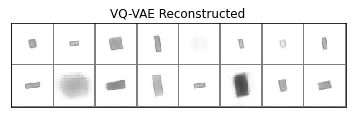

In [19]:
latent_centers = torch.from_numpy(kmeans.cluster_centers_.reshape(n_clusters, 64, 14, 14).astype('float32')).to(device)
vqae.eval()
valid_recon = vqae.decoder(latent_centers)
def show(img, title):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)
plt.figure()  # Create a new plot
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.savefig(f"{n_clusters}_VQrecon.png", bbox_inches='tight')

In [20]:
def rescale_img(img): #B,C,H,W
    rescale = transforms.Compose([transforms.Resize(112),
                                  transforms.Pad(56, fill=1.0)])
    return rescale(img)
rescaled_recon = rescale_img(valid_recon+0.5)

for i in range(rescaled_recon.shape[0]):
    save_image(rescaled_recon[i], f'../results/recon_img/{n_clusters}cluster-img{i}.jpg')
    
print('save to results/recon_img/*.jpg')

save to results/recon_img/*.jpg


### For rhino mapping-back 

In [22]:
import glob
import cv2
import os
import numpy as np
import torchvision.transforms.functional as TF
import imageio
import matplotlib.pyplot as plt

In [23]:
folder_path = "../results/recon_img/"  
img_files = []
for filename in os.listdir(folder_path):
    if "5cluster" in filename:
        print(filename)
        img_files.append(filename)

5cluster-img0.jpg
5cluster-img0_rectangle.jpg
5cluster-img1.jpg
5cluster-img1_rectangle.jpg
5cluster-img2.jpg
5cluster-img2_rectangle.jpg
5cluster-img3.jpg
5cluster-img3_rectangle.jpg
5cluster-img4.jpg
5cluster-img4_rectangle.jpg


In [24]:
def calc_height(image_path):
    print(image_path)
    fullpath = f"../results/recon_img/"+str(image_path)
    image = cv2.imread(fullpath)
    height, width, channels = image.shape
    print(height, width, channels)
    
    # Calculate the starting and ending indices for the central region
    start = (height - central_region_size) // 2
    end = start + central_region_size
    
    # Get the average pixel value in the central region for each channel
    central_region = image[start:end, start:end, :]
    average_pixel_value = np.mean(central_region, axis=(0,1))
    
    # Draw a red rectangle around the central region
    img_with_rectangle = np.copy(image)
    cv2.rectangle(img_with_rectangle, (start, start), (end, end), (0, 0, 255), 2)  # Draw red rectangle
    
    # Save the image with the red rectangle
    image_with_rectangle_path = fullpath.replace(".jpg", "_rectangle.jpg")  # Update the path as per your requirement
    imageio.imwrite(image_with_rectangle_path, img_with_rectangle)
    print(image_with_rectangle_path)
    return average_pixel_value

central_region_size = 10
height_info = []
for image_path in img_files:
    average_pixel_value = calc_height(image_path)
    height_info.append(average_pixel_value[0])

5cluster-img0.jpg
224 224 3
../results/recon_img/5cluster-img0_rectangle.jpg
5cluster-img0_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img0_rectangle_rectangle.jpg
5cluster-img1.jpg
224 224 3
../results/recon_img/5cluster-img1_rectangle.jpg
5cluster-img1_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img1_rectangle_rectangle.jpg
5cluster-img2.jpg
224 224 3
../results/recon_img/5cluster-img2_rectangle.jpg
5cluster-img2_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img2_rectangle_rectangle.jpg
5cluster-img3.jpg
224 224 3
../results/recon_img/5cluster-img3_rectangle.jpg
5cluster-img3_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img3_rectangle_rectangle.jpg
5cluster-img4.jpg
224 224 3
../results/recon_img/5cluster-img4_rectangle.jpg
5cluster-img4_rectangle.jpg
224 224 3
../results/recon_img/5cluster-img4_rectangle_rectangle.jpg


In [25]:
height_info

[170.12, 206.37, 176.69, 209.12, 132.11, 187.8, 177.97, 206.41, 213.68, 217.87]

In [26]:
# Loop through each image
image_paths = glob.glob('recon_img/*.png')
lower_thres = 0.3
higher_thres = 0.7
for image_path in image_paths:
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.convertScaleAbs(gray)
    edges = cv2.Canny(gray, lower_thres, higher_thres)  # Adjust the threshold values as needed

    # Save the edge image
    filename = os.path.splitext(os.path.basename(image_path))[0]  # Extract the filename without extension
    edge_image_path = f'edge_img/{filename}_edge.jpg'
    cv2.imwrite(edge_image_path, edges)

### get aggregated area

In [126]:
sum_of_area_list = []

directory_path = r'../results/area_aggregation'  # Use r prefix for raw string
# Create an empty DataFrame to store the objectIDs
objectID_df = pd.DataFrame(columns=[0])
# Load the JSON data from the file

for index in tqdm(num_indexes):
    csv_df = get_csv_df(index)
    # filtered_df = csv_df[csv_df['index'].isin(objectid_ref_df['OBJECTID'])]
    # print(filtered_df.shape)
    # sum_of_area, merged_df=calculate_aggregated_areas(filtered_df)
    sum_of_area = get_sum_of_area()
    sum_of_area_list.append(sum_of_area)
    # merged_df.to_csv(f'../results/area_aggregation/5cluster_{index}_merged.csv',index=False)
    # objectID_df = pd.concat([objectID_df, merged_df['objectID']], ignore_index=True)
# objectID_df.to_csv('../results/area_aggregation/objectID.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.52it/s]

csv_df shape = (4259, 7), objectid_ref_df = (13367, 5)
merged_df shape = (4259, 12)
csv_df shape = (2730, 7), objectid_ref_df = (13367, 5)
merged_df shape = (2730, 12)
csv_df shape = (852, 7), objectid_ref_df = (13367, 5)
merged_df shape = (852, 12)
csv_df shape = (4423, 7), objectid_ref_df = (13367, 5)
merged_df shape = (4423, 12)
csv_df shape = (1105, 7), objectid_ref_df = (13367, 5)
merged_df shape = (1105, 12)


In [113]:
objectid_ref_df

,Unnamed: 0,OBJECTID,idf.kw,FootprintArea.m2,building.area.m2
0,11,37,SingleFamily-pre-1980,91.316398,69.3963
1,14,46,SingleFamily-2004,99.909763,193.0462
2,20,52,MultiFamily-pre-1980,94.014890,189.7018
3,24,57,SingleFamily-pre-1980,341.028058,314.1878
4,28,63,SingleFamily-2004,268.205501,325.5216
...,...,...,...,...,...
13362,15476,25638,SingleFamily-pre-1980,227.679816,121.2345
13363,15477,25642,MultiFamily-pre-1980,62.026620,262.0709
13364,15478,25643,MultiFamily-2004,129.942767,464.5000
13365,15479,25644,SingleFamily-pre-1980,164.018356,176.6958


In [114]:
objectid_ref_df.sum()

Unnamed: 0                                                  107901183
OBJECTID                                                    187510622
idf.kw              SingleFamily-pre-1980SingleFamily-2004MultiFam...
FootprintArea.m2                                       3274820.381714
building.area.m2                                          3597987.272
dtype: object

In [130]:
sum_of_area_list

[1141716.3815,
 728261.4942000001,
 243567.91410000002,
 1193941.6029,
 291030.5241]

In [132]:
new_df = pd.DataFrame({'index': num_indexes, 'area': sum_of_area_list})
new_df.to_csv('area_aggregation_kmeans_5.csv')